In [229]:
import pandas as pd
import matplotlib.pyplot as plt 
from matplotlib.pyplot import figure
from matplotlib.patches import Circle, Rectangle, Arc
import seaborn as sns

import math
from nba_api.stats.endpoints import ShotChartDetail, CommonPlayerInfo, CommonAllPlayers, PlayerCareerStats
from nba_api.stats.static import players, teams

In [230]:
# Create class that takes the players name and grabs the team and player id necessary based on the season

class shot_chart:
    
    def __init__(self, name, year): 

        self.player_name = name
        self.season = year
    
    def grab_ids(self):
        player_id = players.find_players_by_full_name(self.player_name)
        ids = PlayerCareerStats(player_id=player_id[0]['id']).season_rankings_regular_season.get_data_frame()[['PLAYER_ID','TEAM_ID','SEASON_ID']]
        ids = ids.loc[ids['SEASON_ID'] == self.season]
        return ids
    
    def grab_shot_chart(self):
    
        df = self.grab_ids()
        
        season_start_date = df['SEASON_ID'].str[0:4] + '0901'
        season_end_date = df['SEASON_ID'].str[0:2] + df['SEASON_ID'].str[5:7] + '0430'
             
        shot_chart_makes = ShotChartDetail(player_id=df['PLAYER_ID'],team_id=df['TEAM_ID'],context_measure_simple='FGM').shot_chart_detail.get_data_frame()
        shot_chart_misses = ShotChartDetail(player_id=df['PLAYER_ID'],team_id=df['TEAM_ID'],context_measure_simple='FGA').shot_chart_detail.get_data_frame()
        
        shot_chart_all = pd.concat([shot_chart_misses,shot_chart_makes])
        shot_chart = shot_chart_all.loc[(shot_chart_all['GAME_DATE'].astype(int) >= int(season_start_date)) & (shot_chart_all['GAME_DATE'].astype(int) <= int(season_end_date))] 

        return shot_chart
    
    def draw_court(ax=None, color='black', lw=2, outer_lines=False):
        # If an axes object isn't provided to plot onto, just get current one
        if ax is None:
            ax = plt.gca()
    
        # Create the various parts of an NBA basketball court
    
        # Create the basketball hoop
        # Diameter of a hoop is 18" so it has a radius of 9", which is a value
        # 7.5 in our coordinate system
        hoop = Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False)
    
        # Create backboard
        backboard = Rectangle((-30, -7.5), 60, -1, linewidth=lw, color=color)
    
        # The paint
        # Create the outer box 0f the paint, width=16ft, height=19ft
        outer_box = Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color,
                              fill=False)
        # Create the inner box of the paint, widt=12ft, height=19ft
        inner_box = Rectangle((-60, -47.5), 120, 190, linewidth=lw, color=color,
                              fill=False)
    
        # Create free throw top arc
        top_free_throw = Arc((0, 142.5), 120, 120, theta1=0, theta2=180,
                             linewidth=lw, color=color, fill=False)
        # Create free throw bottom arc
        bottom_free_throw = Arc((0, 142.5), 120, 120, theta1=180, theta2=0,
                                linewidth=lw, color=color, linestyle='dashed')
        # Restricted Zone, it is an arc with 4ft radius from center of the hoop
        restricted = Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=lw,
                         color=color)
    
        # Three point line
        # Create the side 3pt lines, they are 14ft long before they begin to arc
        corner_three_a = Rectangle((-220, -47.5), 0, 140, linewidth=lw,
                                   color=color)
        corner_three_b = Rectangle((220, -47.5), 0, 140, linewidth=lw, color=color)
        # 3pt arc - center of arc will be the hoop, arc is 23'9" away from hoop
        # I just played around with the theta values until they lined up with the 
        # threes
        three_arc = Arc((0, 0), 475, 475, theta1=22, theta2=158, linewidth=lw,
                        color=color)
    
        # Center Court
        center_outer_arc = Arc((0, 422.5), 120, 120, theta1=180, theta2=0,
                               linewidth=lw, color=color)
        center_inner_arc = Arc((0, 422.5), 40, 40, theta1=180, theta2=0,
                               linewidth=lw, color=color)
    
        # List of the court elements to be plotted onto the axes
        court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw,
                          bottom_free_throw, restricted, corner_three_a,
                          corner_three_b, three_arc, center_outer_arc,
                          center_inner_arc]
    
        if outer_lines:
            # Draw the half court line, baseline and side out bound lines
            outer_lines = Rectangle((-250, -47.5), 500, 470, linewidth=lw,
                                    color=color, fill=False)
            court_elements.append(outer_lines)
    
        # Add the court elements onto the axes
        for element in court_elements:
            ax.add_patch(element)
    
        return ax
    
    def create_shot_chart(self):
        
        df = self.grab_shot_chart()
        plt.figure(figsize=(20,5))
        sns.jointplot(df['LOC_X'].loc[(df['SHOT_MADE_FLAG'] == 1) & (df['SHOT_DISTANCE'] >= 8)], df['LOC_Y'].loc[(df['SHOT_MADE_FLAG'] == 1) & (df['SHOT_DISTANCE'] >= 8)],kind="kde") # height should be three times width

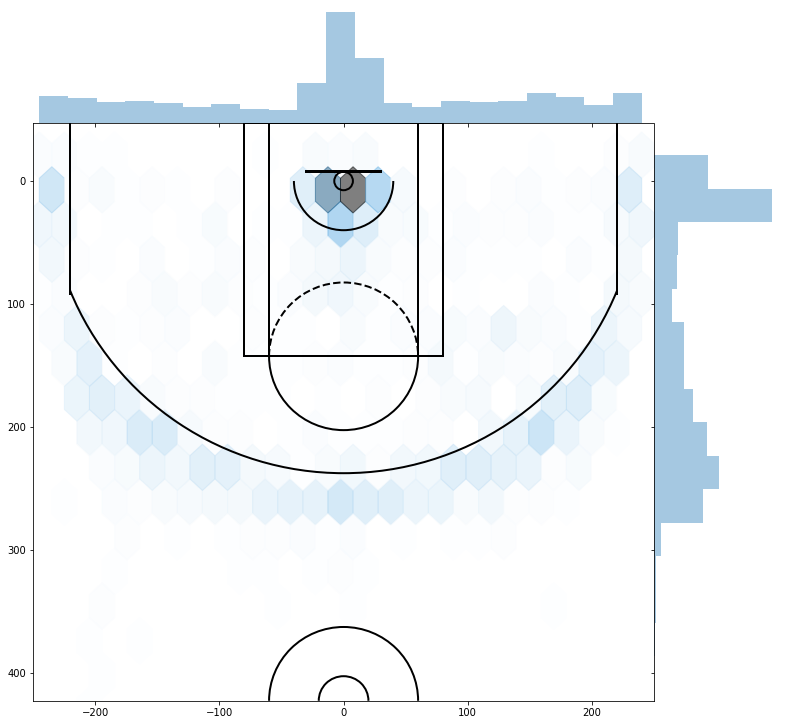

In [234]:
shots = sns.jointplot(df.LOC_X, df.LOC_Y, stat_func=None,kind='hex', space=0, alpha=0.5)
shots.fig.set_size_inches(12,11)

# A joint plot has 3 Axes, the first one called ax_joint 
# is the one we want to draw our court onto and adjust some other settings
ax = shots.ax_joint
shot_chart.draw_court(ax)

# Adjust the axis limits and orientation of the plot in order
# to plot half court, with the hoop by the top of the plot
ax.set_xlim(-250,250)
ax.set_ylim(422.5, -47.5)

# Get rid of axis labels and tick marks
ax.set_xlabel('')
ax.set_ylabel('')
ax.tick_params(labelbottom='off', labelleft='off')

# Add a title
ax.set_title('James Harden FGA \n2014-15 Reg. Season', 
             y=1.2, fontsize=18)

# Add Data Scource and Author

plt.show()

In [170]:
df

,GRID_TYPE,GAME_ID,GAME_EVENT_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_NAME,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,...,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG,GAME_DATE,HTM,VTM
6604,Shot Chart Detail,0021500003,6,201939,Stephen Curry,1610612744,Golden State Warriors,1,10,56,...,Center(C),Less Than 8 ft.,3,12,31,1,1,20151027,GSW,NOP
6605,Shot Chart Detail,0021500003,9,201939,Stephen Curry,1610612744,Golden State Warriors,1,10,29,...,Left Side Center(LC),24+ ft.,26,-176,195,1,0,20151027,GSW,NOP
6606,Shot Chart Detail,0021500003,14,201939,Stephen Curry,1610612744,Golden State Warriors,1,9,34,...,Center(C),Less Than 8 ft.,2,20,9,1,0,20151027,GSW,NOP
6607,Shot Chart Detail,0021500003,19,201939,Stephen Curry,1610612744,Golden State Warriors,1,9,13,...,Left Side Center(LC),24+ ft.,27,-197,193,1,1,20151027,GSW,NOP
6608,Shot Chart Detail,0021500003,36,201939,Stephen Curry,1610612744,Golden State Warriors,1,7,11,...,Center(C),Less Than 8 ft.,0,-4,8,1,1,20151027,GSW,NOP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8195,Shot Chart Detail,0021501227,322,201939,Stephen Curry,1610612744,Golden State Warriors,3,5,43,...,Center(C),Less Than 8 ft.,2,20,16,1,1,20160413,GSW,MEM
8196,Shot Chart Detail,0021501227,350,201939,Stephen Curry,1610612744,Golden State Warriors,3,2,43,...,Center(C),24+ ft.,30,4,303,1,0,20160413,GSW,MEM
8197,Shot Chart Detail,0021501227,364,201939,Stephen Curry,1610612744,Golden State Warriors,3,1,27,...,Center(C),Less Than 8 ft.,2,10,21,1,1,20160413,GSW,MEM
8198,Shot Chart Detail,0021501227,372,201939,Stephen Curry,1610612744,Golden State Warriors,3,0,32,...,Right Side Center(RC),24+ ft.,27,209,183,1,0,20160413,GSW,MEM


In [ ]:
player_info

In [ ]:
x 